# Models training
In this notebook we train and analyze LSTM models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [42]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from collections import Counter
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from landmarks_augmentator import produce_augmentations

In [44]:
with open('landmarks_subset.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)
for key in list(subset_landmarks.keys()):
    if len(subset_landmarks[key]) == 0:
        del subset_landmarks[key]

landmarks = {key: [] for key in subset_landmarks.keys()}

LANDMARKS_LENGTH = 543 # Fixed and determined by the mediapipe package. The total number of landmarks in the 4 categories.

for key, video in subset_landmarks.items():
    new_video = np.zeros((len(video),LANDMARKS_LENGTH,3)) # frame x landdmarks x coordinates
    for i, frame in enumerate(video):
        pose = frame['pose'][:,:3] if frame['pose'].shape == (33, 4) else frame['pose'].reshape((33, 4))[:,:3]
        lh = frame['lh'] if frame['lh'].shape == (21, 3) else frame['lh'].reshape((21, 3))
        rh = frame['rh'] if frame['rh'].shape == (21, 3) else frame['rh'].reshape((21, 3))
        face = frame['face'] if frame['face'].shape == (468, 3) else frame['face'].reshape((468, 3))
        frame_landmarks = np.vstack((pose, lh, rh, face))
        new_video[i] = frame_landmarks
    landmarks[key] = new_video

data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object},index_col=0)
data_info = data_info.loc[data_info.video_id.isin(subset_landmarks.keys())]
subset_words = data_info.loc[data_info.video_id.isin(subset_landmarks.keys()),'word'].unique()

POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1

In [45]:
subset_words

array(['walk', 'woman', 'dog', 'man', 'shirt', 'tall', 'dark', 'pizza',
       'play', 'short', 'basketball', 'have', 'red', 'room', 'cold',
       'daughter', 'dress', 'small', 'cheese', 'delicious', 'afternoon',
       'morning', 'big', 'lazy', 'top', 'every', 'beautiful', 'taste',
       'wear', 'empty', 'lamp'], dtype=object)

## 0.2 Test-train split

List of hyperparameters:
- **Dimensions** Check wether 3D is significanly more sufficient than 2D
- **Face landmarks** Do the face landmarks contribute much? If yes, how many of them should we take?


In [46]:
PICKED_FRAMES = 24 # min([len(video) for video in landmarks.values()])
DIMENSTIONS = 3
USE_AUGMENTATIONS = True# Use augmented videos
    

In [83]:
#train_signer_ids = [118, 31, 59, 11, 115, 94, 6, 21, 10, 38, 56, 41, 4, 45, 32, 46, 13,
#                    42, 39, 17, 89, 60, 35, 15, 3, 92, 93, 34, 107, 28, 99, 37, 8, 97,
#                    70, 19, 91, 106, 63, 29, 26, 117, 66, 119, 50, 103, 120, 95, 78, 27,
#                    108, 57, 53, 75, 104, 43, 40, 77, 1, 33, 22, 105, 48, 73, 23]
#val_signer_ids = [2, 52, 12, 98, 88]
#test_signer_ids = [59, 115, 90, 4, 116, 100, 101, 102, 96, 90]
#
#num_of_words = data_info[data_info["word"].isin(subset_words)]["word"].nunique()
#subset_data = data_info[data_info["word"].isin(subset_words)]
#subset_train_data = subset_data[subset_data["signer_id"].isin(train_signer_ids)]
#subset_test_data = subset_data[subset_data["signer_id"].isin(val_signer_ids)]
#subset_validation_data = subset_data[subset_data["signer_id"].isin(test_signer_ids)]
#
#print(f"subset train data count: {len(subset_train_data)}")
#print(f"subset test data count: {len(subset_test_data)}")
#print(f"subset validation data count: {len(subset_validation_data)}")
#print(f"num of words: {num_of_words}")

In [47]:
# train, val, and test as given by the data authors, should find a better split
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])

In [48]:
test_landmarks = {id:video for id, video in landmarks.items() if id in test_ids}
validation_landmarks = {id:video for id, video in landmarks.items() if id in validation_ids}


## 0.3 Produce Augmentations 
For train set only

In [49]:
#subset_landmarks = produce_augmentations(subset_landmarks,data_info)
train_landmarks = {id:video for id, video in landmarks.items() if id in train_ids}
len(train_landmarks)


256

In [50]:
train_landmarks = produce_augmentations(train_landmarks, data_info.loc[data_info.video_id.isin(train_landmarks.keys())])
len(train_landmarks)

1280

## 0.3 Prepare data to fit in LSTM
Take same amount of frames from each video.
<p style="color:red;">hopefully this is a temporary phase in the development </p>

In [36]:
def pick_frames(video,num_frames):
    ''' Take a subset of the frames, evenly spread over the whole video
    ----------------------------------------------------------------------------------------------------------
        EDIT: After getting the missing data, some video are too short and need more frames instad
              Will it bias the predictions? Nee to consider discarding these examples.
              OR ask chatGPT to write a function to make it a smooth "slow motion", I don't have time for this
    ----------------------------------------------------------------------------------------------------------
    '''
    if len(video) == num_frames:
        return video
    if len(video) < num_frames:
        video_longer = video.copy()
        for _ in range(len(video),num_frames):
            video_longer = np.vstack((video_longer,[video_longer[-1]]))
        return video_longer
    step_size = len(video) // num_frames
    video_shorter = video[::step_size][:num_frames]
    return video_shorter

In [52]:
words = subset_words 

#lstm_landmarks = {}
#for word in words:
#    videos = data_info.loc[data_info.word==word,'video_id']
#    for vid in videos:
#        lstm_landmarks[vid] = pick_frames(subset_landmarks[vid][:,POSE+LH+RH,:DIMENSTIONS].copy(),PICKED_FRAMES)
#        for key in subset_landmarks:
#            if key.split('_')[0] == vid:
#                lstm_landmarks[vid] = pick_frames(subset_landmarks[vid][:,POSE+LH+RH,:DIMENSTIONS].copy(),PICKED_FRAMES)
#for id, video in list(subset_landmarks.items()):
#    if id not in train_ids:
#        subset_landmarks[id] = pick_frames(video[:,POSE+LH+RH,:DIMENSTIONS],PICKED_FRAMES)
#    else: # Clear up space, maybe irrelevant because we soon delete the whole subset_landmarks object
#        del subset_landmarks[id]

for id, video in train_landmarks.items():
    train_landmarks[id] = pick_frames(video,PICKED_FRAMES)
    original_id = id.split('_')[0]
    if original_id != id and id not in data_info.video_id: # if augmented type, add its label to the data_info table
        augmented_row = data_info.loc[data_info.video_id==original_id,:]
        data_info.loc[data_info['video_id'] == original_id, 'video_id'] = id
        data_info = pd.concat([data_info, augmented_row])

print(f'{len(train_landmarks)} videos in total for {len(words)} words')

for id, video in test_landmarks.items():
    test_landmarks[id] = pick_frames(video, PICKED_FRAMES)

print(f'{len(test_landmarks)} videos in total for {len(words)} words')

for id, video in validation_landmarks.items():
    validation_landmarks[id] = pick_frames(video, PICKED_FRAMES)

print(f'{len(validation_landmarks)} videos in total for {len(words)} words')

1280 videos in total for 31 words
49 videos in total for 31 words
66 videos in total for 31 words


## 0.4 Train test split

In [53]:
for video_id, video in train_landmarks.items():
    train_landmarks[video_id] = np.array([frame.flatten() for frame in video])
for video_id, video in test_landmarks.items():
    test_landmarks[video_id] = np.array([frame.flatten() for frame in video])
for video_id, video in validation_landmarks.items():
    validation_landmarks[video_id] = np.array([frame.flatten() for frame in video])

X_train = np.array([video for video in train_landmarks.values()])
y_train = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in list(train_landmarks.keys())]

X_val = np.array([video for video in validation_landmarks.values()])
y_val = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in validation_landmarks.keys()]

X_test = np.array([video for video in test_landmarks.values()])
y_test = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in test_landmarks.keys()]

# Shuffle the train set
num_instances = X_train.shape[0]
shuffled_indices = np.arange(num_instances)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = np.array(y_train)[shuffled_indices]

## 1.1 BASELINE MODEL - Landmarks + Regression Model

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def svm(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

In [55]:
X_train.shape

(1280, 24, 1629)

In [49]:
model_lg = logistic_regression(X_train, X_val, y_train, y_val)
model_svm = svm(X_train, X_val, y_train, y_val)
model_rf = random_forest(X_train, X_val, y_train, y_val)

ValueError: Found array with dim 3. LogisticRegression expected <= 2.

## 1.2 BASELINE MODEL - Landmarks + LSTM

In [39]:
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam


MODEL_VERSION = 3 # Model 3 is trained on ~500 words of data

def load_tf_model(folder_path):
    if not os.path.exists(folder_path):
        return False
    for file in os.listdir(folder_path):
        if file.endswith('.keras'):
            return keras.saving.load_model(os.path.join(folder_path,file))
    return False
folder_path = os.path.join('sign-to-text-interface','serving','lstm',str(MODEL_VERSION))
#model = load_tf_model(folder_path)
model = False

index_to_word = {word: i for i, word in enumerate(words)}
y_train_categorical = to_categorical([index_to_word[word] for word in y_train], num_classes=len(words))
y_val_categorical = to_categorical([index_to_word[word] for word in y_val], num_classes=len(words))
if not model:    
    input_shape = (X_train[0].shape)  #Hopefully we can do variable number of frames later
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(256, return_sequences=False, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(len(words), activation='softmax'))
    adam_optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │       900,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639,199 (6.25 MB)

 Trainable params: 1,639,199 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from keras.callbacks import ModelCheckpoint

#filepath = "model_500.h5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

#if os.path.exists(filepath):
    #print('loaded weights and procceed training')
    #model.load_weights(checkpoint_filepath)
#history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=8, callbacks=callbacks_list, validation_data = (X_val, y_val_categorical))
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=8, validation_data = (X_val, y_val_categorical))

Epoch 1/100
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.0499 - loss: 3.3340

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 9 and 1629 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,9], [1629,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 9), dtype=float32)
  • states=('tf.Tensor(shape=(None, 128), dtype=float32)', 'tf.Tensor(shape=(None, 128), dtype=float32)')
  • training=False

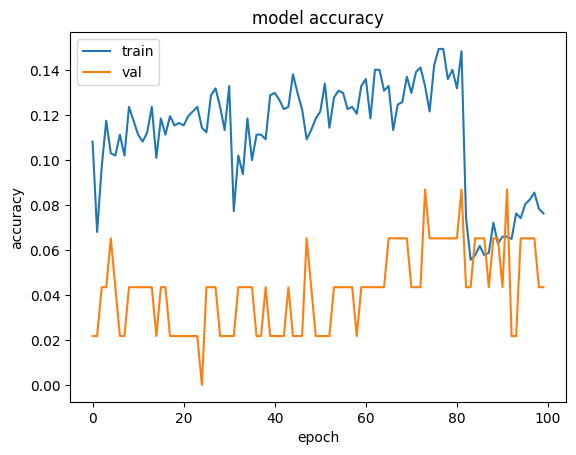

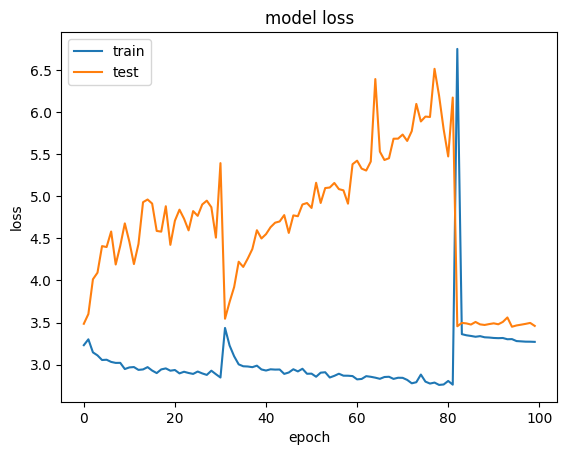

In [44]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Load the weights with the best performance

In [45]:
os.path.join('sign-to-text-interface','serving','lstm',str(MODEL_VERSION),'sign_to_text.keras')

'sign-to-text-interface/serving/lstm/3/sign_to_text.keras'

In [275]:
model.load_weights(filepath)
model.save(os.path.join('sign-to-text-interface','serving','lstm',str(MODEL_VERSION),'sign_to_text.keras'))

Let's find how many correctly classified instances we get

In [46]:
count_train = Counter(y_train)
def predictions_stats(X_test, y_test):
    correct = {}
    for i,j in enumerate(model.predict(X_test).argmax(axis=1)):
        if y_test[i] == words[j]:
            correct[y_test[i]] = correct.get(y_test[i],0) + 1
    count_test = Counter(y_test)
    pred_stats = []
    for word, count in correct.items():
        row_data = {"word": word, "correct_count": count, "appeared_test": count_test.get(word, 0), "train_instances": count_train.get(word, 0)}
        pred_stats.append(row_data)

    # Concatenate the list of dictionaries to the DataFrame
    pred_stats = pd.concat([ pd.DataFrame(columns=["word","correct_count","appeared_test","train_instances"]), pd.DataFrame(pred_stats)], ignore_index=True)
    return pred_stats
display(predictions_stats(X_val, y_val))
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,word,correct_count,appeared_test,train_instances
0,woman,1,1,45
1,dark,1,1,45


The mean and median amount of instances per word in the train set are: 31.29032258064516 30.0


In [34]:
count_train = Counter(y_train)
def predictions_stats(on = 'val'):
    if on == 'val':
        X, y, video_ids = X_val, y_val, validation_ids
    else:
        X, y, video_ids = X_test, y_test, test_ids
    prob_scores = np.zeros((len(y),3), dtype=object)
    for i,j in enumerate(model.predict(X)):
        prob_scores[i,0] = y[i]
        prob_scores[i,1] = (j>j[index_to_word[y[i]]]).sum()# Highest probability means the word got predicted correctly, we want to analyze how close the word was in case it wasn't predicted
#        if y[i] == words[j]:
#            correct[y[i]] = correct.get(y[i],0) + 1
    prob_scores[:,2] = list(data_info.loc[data_info.video_id.isin(video_ids),'video_id'])
    return pd.DataFrame(prob_scores,columns=['word','score','video_id']).sort_values(['score','word'],ascending=[False,True])
    #count_test = Counter(y)
    #for word, count in correct.items():
    #    row_data = {"word": word, "correct_count": count, "appeared_test": count_test.get(word, 0), "train_instances": count_train.get(word, 0)}
    #    pred_stats.append(row_data)
    #pred_stats = pd.concat([ pd.DataFrame(columns=["word","correct_count","appeared_test","train_instances"]), pd.DataFrame(pred_stats)], ignore_index=True)
    #return pred_stats
word_scores = predictions_stats().sort_values(['score','word'],ascending=[True,True])
display(predictions_stats())
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,word,score,video_id
44,empty,30,19049
26,daughter,29,14750
39,beautiful,28,05558
1,woman,27,63669
35,lazy,26,66019
43,wear,25,62615
41,taste,24,56972
45,empty,23,19051
38,every,23,19849
8,tall,22,66591


The mean and median amount of instances per word in the train set are: 31.29032258064516 30.0


In [326]:
word_scores.loc[(word_scores.score<10) & (word_scores.score>1)].shape

(121, 3)

<h2 style="color:red">TODO: Continue exploration of model 3 and its results</h2>
<ul style="color:red">
    <li>Make statistics of the results</li>
    <li>Try to train further, perhaps with dropout or normalization</li>
</ul>

Altough I did not output it here above, I noticed that the overfitted model got always only one word correct: "drink", it is worth investigating why. Perhaps the videos for it were too short and therefore the frames were duplicated to fit the input size for the model.

We see that to get better reults we need more augmentations.

In [144]:
# Helper function for self use, get video ids for a word in a particular set
def find_video_id(word,set = validation_ids):
    df = pd.concat([data_info.loc[data_info.video_id==id,['video_id','word']] for id in lstm_landmarks.keys() if id in set])
    return df.loc[df.word == word]
#use like this:
#find_video_id('short',validation_ids)

## 1.3 LSTM Version 2

In [25]:
MODEL_VERSION = 2
folder_path = os.path.join("serving","lstm",str(MODEL_VERSION))
model = load_tf_model(folder_path)

if not model:    
    input_shape = (lstm_landmarks[list(lstm_landmarks.keys())[0]].shape)  #Hopefully we can do variable number of frames later
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=input_shape))
    model.add(LSTM(256, return_sequences=True, activation='relu'))
    model.add(LSTM(256, return_sequences=True, activation='relu'))
    model.add(LSTM(128, return_sequences=False, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(words), activation='softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    model.fit(X_train, y_train_categorical, epochs=100, batch_size=8)
    model.save(os.path.join('serving','lstm',str(MODEL_VERSION),'sign_to_text.keras'))

Epoch 1/100
106/106 [==============================] - 12s 68ms/step - loss: 3.5270 - categorical_accuracy: 0.0462
Epoch 2/100
106/106 [==============================] - 7s 64ms/step - loss: 3.3592 - categorical_accuracy: 0.0581
Epoch 3/100
106/106 [==============================] - 9s 81ms/step - loss: 3.0617 - categorical_accuracy: 0.0652
Epoch 4/100
106/106 [==============================] - 8s 74ms/step - loss: 2.9307 - categorical_accuracy: 0.0841
Epoch 5/100
106/106 [==============================] - 7s 70ms/step - loss: 2.8648 - categorical_accuracy: 0.0900
Epoch 6/100
106/106 [==============================] - 8s 74ms/step - loss: 22.1359 - categorical_accuracy: 0.0995
Epoch 7/100
106/106 [==============================] - 8s 74ms/step - loss: 2.8907 - categorical_accuracy: 0.1066
Epoch 8/100
106/106 [==============================] - 8s 79ms/step - loss: 2.8154 - categorical_accuracy: 0.1055
Epoch 9/100
106/106 [==============================] - 8s 71ms/step - loss: 2.6906 - c

In [31]:
display(per_stats(X_test = X_val,y_test = y_val))
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))

7/7 [==============================] - 1s 69ms/step


,word,correct_count,appeared_test,train_instances
0,tall,4,8,40
1,man,4,8,40
2,taste,5,5,25
3,dark,4,4,36
4,room,4,8,28
5,dress,5,10,20


The mean and median amount of instances per word in the train set are: 27.225806451612904 28.0


## 1.4 CLIP Embedded

In [31]:
import os
import pickle
import numpy as np
import pandas as pd

# Subset of 500 words -> 7738 Instances
data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object},index_col=0)
top_500 = np.array(Counter(data_info.word).most_common(500))[:,0]
data_info = data_info.loc[data_info.word.isin(top_500),:].reset_index(drop=True)

In [104]:
data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object},index_col=0)
data_info['video_id'] = data_info['video_id'].astype('int64')
data_info

,fps_x,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,word,fps_y,width,height,duration
bbox,,,,,,,,,,,,,,,
"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,25.0,256,256,2.56
"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,book,25.0,256,256,2.56
"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,book,25.0,256,256,1.88
"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,book,25.0,256,256,4.96
"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,book,25.0,256,256,3.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[76, 17, 236, 240]",25,-1,1,2,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/9...,0,63186,whistle,25.0,256,256,3.56
"[3, 0, 320, 240]",25,-1,1,3,14,handspeak,train,https://www.handspeak.com/word/w/whistle.mp4,0,63187,whistle,25.0,256,256,0.96
"[68, 14, 212, 192]",25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,0,63188,whistle,25.0,256,256,1.52


In [116]:
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])

In [58]:
import cv2

def pick_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Ensure at least one frame is picked
    num_frames = max(num_frames, 1)
    
    # Calculate step size ensuring the last frame is included
    step = max(total_frames // (num_frames - 1), 1)
    
    frames = []

    for i in range(num_frames):
        frame_index = min(i * step, total_frames - 1)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames

In [ ]:
frames = pick_frames("videos/00376.mp4", 10)
image = arrange_frames_in_image(frames, 2, 5)

In [ ]:
def arrange_frames_in_image(frames, rows, cols):
    # Calculate the dimensions of the output image
    output_height = rows * frames[0].shape[0]
    output_width = cols * frames[0].shape[1]
    
    # Create an empty black image to arrange frames
    output_image = np.zeros((output_height, output_width, 3), dtype=np.uint8)
    
    # Iterate through frames and place them in the output image
    for i in range(rows):
        for j in range(cols):
            frame_index = i * cols + j
            if frame_index < len(frames):
                frame = frames[frame_index]
                start_row = i * frame.shape[0]
                end_row = start_row + frame.shape[0]
                start_col = j * frame.shape[1]
                end_col = start_col + frame.shape[1]
                output_image[start_row:end_row, start_col:end_col, :] = frame
    
    return output_image

rows, cols = 2, 5

In [75]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

def embed_images(img):
    inputs = processor(
        images=img,
        return_tensors="pt",
        padding=True,
        max_length=32,
        truncation=True
    )
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.flatten()

In [88]:
# this is really expensive dont run this
def embed_images_CLIP(video_folder, csv_file_name="data/embed_images_CLIP.csv"):
    processed_videos = []
    count = 0
    for filename in os.listdir(video_folder):
        count = count + 1
        if count % 1000 == 0:
            print(count)
        if filename.endswith(".mp4"):
            video_id = os.path.splitext(filename)[0]
            video_path = os.path.join(video_folder, filename)
            frames = pick_frames(video_path, 10)
            arranged_image = arrange_frames_in_image(frames, 2, 5)
            image_features = embed_images(arranged_image).tolist()
            image_features.insert(0, video_id)
            processed_videos.append(image_features)
    column_names = ['Video_ID'] + [f"Feature_{i}" for i in range(len(processed_videos[0]) - 1)]
    df = pd.DataFrame(processed_videos, columns=column_names)

    df.to_csv(csv_file_name, index=False)
    return df

In [90]:
def load_embed_images_CLIP(csv_file_name="data/embed_images_CLIP.csv"):
    return pd.read_csv(csv_file_name)

In [96]:
data_embed_images = load_embed_images_CLIP()
data_embed_images = data_embed_images.rename(columns={'Video_ID': 'video_id'})

In [119]:
# Preparing Data for Model
merged_df = pd.merge(data_embed_images, data_info, on='video_id')
selected_columns = ['video_id'] + [f"Feature_{i}" for i in range(512)] + ['word']
data = merged_df[selected_columns]

train_indices = data[data['video_id'].isin(train_ids)].index
validation_indices = data[data['video_id'].isin(validation_ids)].index

X_train, X_test = data.iloc[train_indices][[f"Feature_{i}" for i in range(512)]], data.iloc[validation_indices][[f"Feature_{i}" for i in range(512)]]
y_train, y_test = data.iloc[train_indices]['word'], data.iloc[validation_indices]['word']

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def svm(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

In [135]:
regression_model = logistic_regression(X_train, X_test, y_train, y_test)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1026000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60090D+00    |proj g|=  1.14038D-02


 This problem is unconstrained.



At iterate   50    f=  5.58980D+00    |proj g|=  4.10985D-03

At iterate  100    f=  5.58187D+00    |proj g|=  5.53179D-04

At iterate  150    f=  5.57326D+00    |proj g|=  7.76007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    179    190      1     0     0   7.557D-05   5.573D+00
  F =   5.5726811059719177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Accuracy: 0.021961184882533197
Classification Report:                   precision    recall  f1-score   support

               a       0.00      0.00      0.00         2
           a lot       0.00      0.00      0.00         2
        

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [137]:
svm_model = svm(X_train, X_test, y_train, y_test)

Accuracy: 0.035495403472931564
Classification Report:                   precision    recall  f1-score   support

               a       0.00      0.00      0.00         2
           a lot       0.00      0.00      0.00         2
         abdomen       0.50      0.50      0.50         2
            able       0.00      0.00      0.00         2
           about       0.00      0.00      0.00         3
           above       0.00      0.00      0.00         2
          accent       0.00      0.00      0.00         1
          accept       0.00      0.00      0.00         2
        accident       0.00      0.00      0.00         3
      accomplish       0.00      0.00      0.00         2
      accountant       0.00      0.00      0.00         2
          across       0.00      0.00      0.00         2
             act       0.00      0.00      0.00         1
          action       0.00      0.00      0.00         2
          active       0.00      0.00      0.00         2
        activity 

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [138]:
random_forest_model = random_forest(X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

def xgb(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    return model

def cnn(X_train, X_test, y_train, y_test):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(512,)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Fully Connected Neural Network Model:")
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    return model

## 1.5 CLIP Zero Shot Prediction

In [ ]:
def concat_images(video_folder, directory_name="concat_images"):
    count = 0
    for filename in os.listdir(video_folder):
        count = count + 1
        if count % 1000 == 0:
            print(count)
        if filename.endswith(".mp4"):
            video_id = os.path.splitext(filename)[0]
            video_path = os.path.join(video_folder, filename)
            frames = pick_frames(video_path, 10)
            arranged_image = arrange_frames_in_image(frames, 2, 5)
            cv2.imwrite(directory_name + "/" + filename.replace(".mp4", ".jpg"), arranged_image)